# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [4]:
import pandas as pd  # import the neccessary libraries
pd.set_option('display.max_columns', 300)  # display all the columns
pd.set_option('display.max_rows', 100)
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import pickle
from sklearn.neighbors import KNeighborsRegressor  # In case we want to use k-nearest neighbor model
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


plt.style.use('seaborn')
sns.set(style="white")

In [5]:
df = pd.read_csv('kc_house_data_train.csv')# read in the csv file with train data
zip_df = pd.read_csv('zip_code_extra_data.csv')
print(df.shape)  # check the dimensions of the model
df.head()   # print the first 5 rows

(17290, 22)


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [6]:
##### Merge Zipcode Data #####

df = pd.merge(df,zip_df,on='zipcode')
#df.shape

#### Drop Duplicates, keeping most recent sold ####
df['year_sold'] = df['date'].str[0:4].astype(int)
df = df.sort_values(by=['year_sold']).drop_duplicates(['id'],keep='last')
df.drop(columns=['Unnamed: 0'], inplace=True)


In [7]:
#### Dropping columns I dont intend to Use ####
df.drop(columns=['full_time_earnings','part_time_earnings','no_earnings','car_truck_van',
                 'public_transportation','taxi','motorcycle',
       'bike_walk_other', 'work_home', 'less_than_hs', 'high_school_grad',
       'associates', 'bachelors', 'masters', 'professional_school_degree',
       'doctorate', 'public_school_enrollment', 'private_school_enrollment',
       'no_school_enrollment', 'for_rent', 'rented_and_unoccupied',
       'for_sale_only', 'sold_and_unoccupied', 'seasonal_or_rec_use',
       'migrant_worker_housing', 'vacant_other_reasons',
       'in_occupied_housing_units', 'adult_correctional_facility',
       'juvenile_facilities', 'nursing_facilities', 'other_institutional',
       'military_quarters', 'other_noninstitutional',
       'house_owned_with_mortgage', 'house_owned_outright',
       'renter_occupied_housing', 'vacant_households',
       'husband_and_wife_house', 'single_guardian', 'singles',
       'singles_with_roommate', 'male', 'female','male_median_age', 'female_median_age',
         'total_housing_units','land_area', 'water_area_sq_mile',
       'occupied_housing_units'], inplace=True)

In [8]:
#### Try bring down price extreme values ####

IQR = df.price.quantile(0.75) - df.price.quantile(0.25)
upper_limit = df.price.quantile(0.75) + (IQR * 1.5)
upper_limit_extreme = df.price.quantile(0.75) + (IQR * 10)
df['price'] = np.where(df['price'] > upper_limit_extreme, upper_limit, df['price'])

In [9]:
##### Initial Data Cleaning -- Based Mostly off Abnormal Values

#Add column bath/bed
df['bath_per_bed'] = np.where(df['bedrooms'] > 0, df['bathrooms'] / df['bedrooms'], 0)
df.drop(columns=['bathrooms'], inplace=True)

#Add Log_Price
df['log_price'] = np.where(df['price'], np.log(df['price']), df['price'])

#Condesing 33 and 11 Bedroom values to 10
df['bedrooms'] = np.where(df['bedrooms'] > 10, 3, df['bedrooms'])
#House with 0 bedrooms to the Mean Bedrooms
df['bedrooms'] = np.where(df['bedrooms'] == 0, 3, df['bedrooms'])


##### Convert Date to Year_Sold and Month_Sold ####

df['year_sold'] = df['date'].str[0:4].astype(int)
df['month_sold'] = df['date'].str[4:6].astype(int)
df.drop(columns=['date'], inplace=True)

#### Drop Duplicates, keeping the most recent sale of house ####
df = df.sort_values(by=['year_sold']).drop_duplicates(['id'],keep='last')

#### Floors seems to not be very significant, converting to binary (0 = 1 Floor, 1 = Multi-Floors)
df['floors'] = np.where(df['floors'] > 1, 1, 0)

In [10]:
#####Initial Data Cleaning -- Based Mostly off Multicolliniarity

#Drop 'sqft_above' column
df.drop(columns=['sqft_above'], inplace=True)

#Turn 'sqft_basement' into binary "Basement" column
df['basement'] = np.where(df['sqft_basement'] > 0, 1, 0)

#Drop 'sqft_basement' column
df.drop(columns=['sqft_basement'], inplace=True)
df.drop(columns=['sqft_living15'], inplace=True)

In [11]:
##### Zip Codes to Bins #####

price_by_zip = df.groupby('zipcode')['price'].mean().sort_values(ascending=False)
zip_category = pd.cut(price_by_zip, bins =[0,350000,600000,900000,3500000], labels = ['low','medium','high','very_high'])
df['zip_price_level'] = df['zipcode'].apply(lambda x: zip_category.loc[x])
df['zip_price_level'].value_counts()
df = pd.get_dummies(df, columns = ['zip_price_level'], drop_first= True)

In [12]:
##### Add Season column #####

def to_season(x):
    if x == 12 or x == 1 or x == 2:
        return 'cold_month'
    elif x == 3 or x == 4 or x == 5:
        return "warm_month"
    elif x == 6 or x == 7 or x == 8:
        return "warm_month"
    else:
        return 'cold_month'
df['season_sold'] = df['month_sold'].apply(to_season)

##### Get Dummies for Season & Year Sold Columns#####
df = pd.get_dummies(df, columns = ['season_sold'], drop_first= True)
df = pd.get_dummies(df, columns = ['year_sold'], drop_first= True)

#### Drop Uneeded Columns #####
df.drop(columns=['month_sold'], inplace=True)


In [13]:
##### Create Years Old Bins #####
df['age'] = 2020 - df['yr_built']
df.drop(columns=['yr_built'], inplace=True)
bins = [-2,25,50,100,100000]
labels = ['1','2','3','4']
df['age'] = pd.cut(df['age'], bins=bins, labels=labels)
df = pd.get_dummies(df, columns = ['age'], drop_first= True)

##### Create Years since Renovation Column #####
# After EDA showed most houses havent been renovated, changing to binary
df['renovated'] = np.where(df['yr_renovated'] > 0, 1, 0)
df.drop(columns=['yr_renovated'], inplace=True)

In [14]:
##### Create Number of Bedrooms #####

bed_bins = [-1,2,3,5,100]
bed_labels = ['1','2','3','4']
df['bedrooms'] = pd.cut(df['bedrooms'], bins=bed_bins, labels=bed_labels)
df = pd.get_dummies(df, columns = ['bedrooms'], drop_first= True)

In [15]:
##### Get Dummies for Other Categorical Variables #####

def sep_grade(x):
    if x == 13:
        return 'high'
    elif x == 10 or x == 11 or x == 11:
        return "medium"
    else:
        return 'low'
df['grade'] = df['grade'].apply(sep_grade)
df = pd.get_dummies(df, columns = ['grade'], drop_first= True)
## Grade not a great determinant of Price

#Turn condition into binary (Good Condition = 1, Bad Condition = 0)
df['condition'] = np.where(df['condition'] > 2, 1, 0)

df = pd.get_dummies(df, columns = ['view'], drop_first= True)

In [16]:
df.describe()

,id,price,sqft_living,sqft_lot,floors,waterfront,condition,zipcode,lat,long,sqft_lot15,median_age,population,population_density_per_sq_mile,median_home_value,median_household_income,bath_per_bed,log_price,basement,zip_price_level_low,zip_price_level_medium,zip_price_level_very_high,season_sold_warm_month,year_sold_2015,age_2,age_3,age_4,renovated,bedrooms_2,bedrooms_3,bedrooms_4,grade_low,grade_medium,view_1,view_2,view_3,view_4
count,1.717600e+04,1.717600e+04,17176.000000,1.717600e+04,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,1.717600e+04,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000
mean,4.565580e+09,5.389934e+05,2083.797916,1.528810e+04,0.503493,0.008034,0.990743,98078.124185,47.560168,-122.214072,12903.700279,37.998079,30408.712215,4286.441022,4.125304e+05,81059.305193,0.640208,13.050004,0.393689,0.217571,0.421984,0.041977,0.596588,0.324988,0.265894,0.400501,0.067478,0.042152,0.455112,0.392466,0.015836,0.928971,0.070389,0.015312,0.045063,0.023812,0.015603
std,2.874306e+09,3.498100e+05,921.090696,4.243962e+04,0.500002,0.089277,0.095770,53.567173,0.138431,0.140964,27312.449379,3.614341,11072.941907,2946.948318,1.325940e+05,24242.740122,0.213274,0.521982,0.488581,0.412606,0.493890,0.200543,0.490596,0.468384,0.441821,0.490014,0.250855,0.200941,0.497995,0.488314,0.124845,0.256881,0.255809,0.122794,0.207448,0.152468,0.123938
min,1.000102e+06,7.500000e+04,290.000000,5.720000e+02,0.000000,0.000000,0.000000,98001.000000,47.155900,-122.519000,659.000000,23.000000,2971.000000,41.000000,1.671000e+05,40815.000000,0.000000,11.225243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.115433e+09,3.233000e+05,1430.000000,5.080000e+03,0.000000,0.000000,1.000000,98033.000000,47.471300,-122.329000,5110.000000,36.000000,21904.000000,2185.000000,3.084000e+05,63709.000000,0.500000,12.686336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.902300e+09,4.500000e+05,1920.000000,7.641500e+03,1.000000,0.000000,1.000000,98065.000000,47.571800,-122.229000,7623.000000,38.000000,31171.000000,3977.000000,3.862000e+05,77688.000000,0.625000,13.017003,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.300410e+09,6.480000e+05,2550.000000,1.073225e+04,1.000000,0.000000,1.000000,98118.000000,47.678000,-122.125000,10112.250000,40.000000,39816.000000,6279.000000,4.782000e+05,95043.000000,0.750000,13.381646,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.900000e+09,3.850000e+06,13540.000000,1.651359e+06,1.000000,1.000000,1.000000,98199.000000,47.777600,-121.315000,858132.000000,50.000000,58442.000000,15829.000000,1.000001e+06,183833.000000,2.500000,15.163584,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
df.dtypes

id                                  int64
price                             float64
sqft_living                         int64
sqft_lot                            int64
floors                              int64
waterfront                          int64
condition                           int64
zipcode                             int64
lat                               float64
long                              float64
sqft_lot15                          int64
median_age                          int64
population                          int64
population_density_per_sq_mile      int64
median_home_value                 float64
median_household_income           float64
bath_per_bed                      float64
log_price                         float64
basement                            int64
zip_price_level_low                 uint8
zip_price_level_medium              uint8
zip_price_level_very_high           uint8
season_sold_warm_month              uint8
year_sold_2015                    

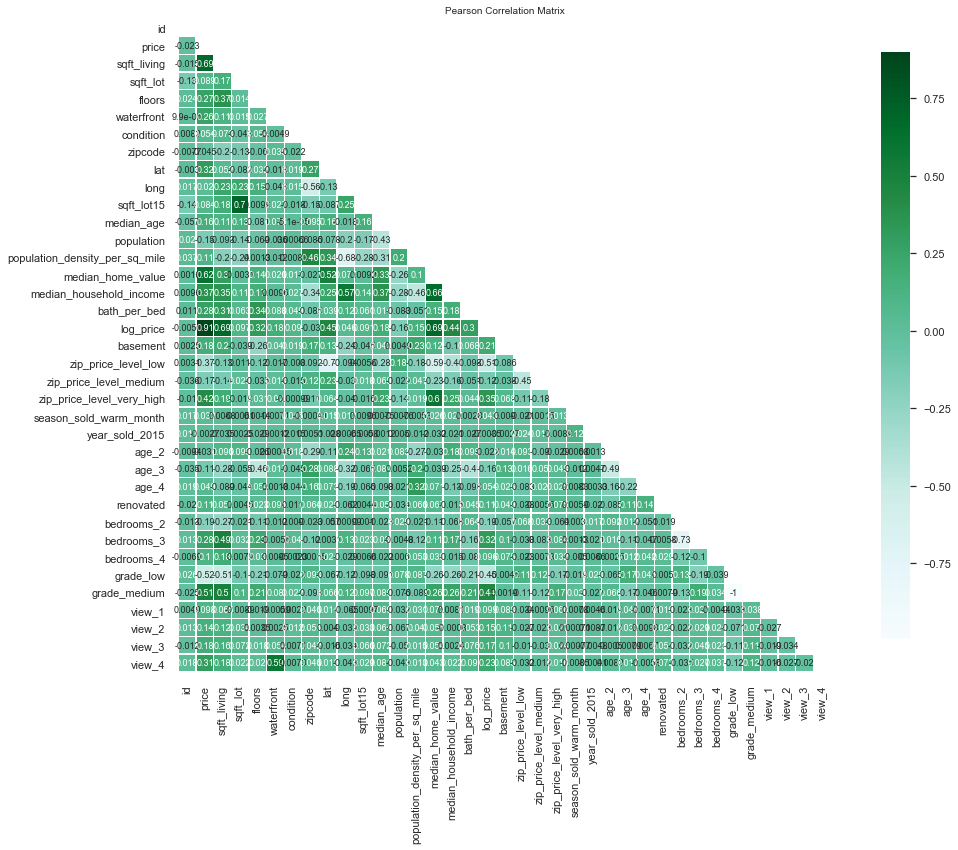

In [18]:
# Checking the correlation between the features
mask = np.zeros_like(df.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(df.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()

### Notes: 
All the sqft variables seem to have a very high correlation. Should think about dropping

Some columns useful for EDA but not Modelling
    
    Price & Log_Price
    yr_renovated & yr_since_renovated


### Below code evaluates VIF

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrices

In [20]:

features = "+".join(df.columns)
features = features.replace('price+', '', 1)
features = features.replace('log_price+', '', 1)
features = features.replace('date+', '', 1)
features = features.replace('id+', '', 1)

y, X = dmatrices('price~' + features, df, return_type='dataframe')

In [21]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [22]:
vif.sort_values(by = "VIF_Factor",ascending=False).head(10)

,VIF_Factor,features
0,6.751932e+06,Intercept
29,1.087264e+02,grade_low
30,1.065144e+02,grade_medium
13,1.068821e+01,median_home_value
17,6.075844e+00,zip_price_level_low
14,5.426592e+00,median_household_income
27,4.925975e+00,bedrooms_3
12,4.197418e+00,population_density_per_sq_mile
8,4.039715e+00,long
1,3.307535e+00,sqft_living


VIF Notes: 
    
    VIF score of 'inf' means these variables show almost perfect correlation. Which proves that sqft variables show 
    multicollinearity
    
    VIF < 3 is ideal. VIF < 10 is sufficient

In [23]:
##### OLS Regression Model #####
features_df = df.drop(columns=['id', 'price','log_price'])
str_features_col= "+".join(features_df)
mlr_model = smf.ols(formula=f'price~{str_features_col}', data=df).fit()
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     1787.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:10:14   Log-Likelihood:            -2.3062e+05
No. Observations:               17176   AIC:                         4.613e+05
Df Residuals:                   17141   BIC:                         4.616e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       7.629e+06   3.26e+06      2.343      0.019    1.25e+06     1.4e+07
sqft_living                      184.2582      2.475     74.459      0.000     179.408     189.109
sqft_lot                           0.2685      0.042      6.412      0.000       0.186       0.351
floors                         -1.013e+04   3527.263     -2.872      0.004    -1.7e+04   -3215.609
waterfront                      4.173e+05   1.76e+04     23.757      0.000    3.83e+05    4.52e+05
condition                       4.351e+04   1.32e+04      3.298      0.001    1.77e+04    6.94e+04
zipcode                         -294.4176     31.753     -9.272      0.000    -356.656    -232.179
lat                             1.831e+05   1.44e+04     12.695      0.000    1.55e+05    2.11e+05
long                            -1.07e+05   1.79e+04     -5.988      0.000   -1.42e+05    -7.2e+04
sqft_lot15                         0.0181      0.066      0.274      0.784      -0.112       0.148
median_age                     -4364.4110    528.395     -8.260      0.000   -5400.119   -3328.703
population                        -0.6642      0.138     -4.814      0.000      -0.935      -0.394
population_density_per_sq_mile    12.7645      0.871     14.650      0.000      11.057      14.472
median_home_value                  0.7160      0.031     23.169      0.000       0.655       0.777
median_household_income           -0.8577      0.120     -7.122      0.000      -1.094      -0.622
bath_per_bed                     5.99e+04   8534.395      7.019      0.000    4.32e+04    7.66e+04
basement                       -3.714e+04   3152.450    -11.783      0.000   -4.33e+04    -3.1e+04
zip_price_level_low            -9.074e+04   7487.308    -12.119      0.000   -1.05e+05   -7.61e+04
zip_price_level_medium         -5.235e+04   4377.681    -11.958      0.000   -6.09e+04   -4.38e+04
zip_price_level_very_high       2.028e+05   1.03e+04     19.722      0.000    1.83e+05    2.23e+05
season_sold_warm_month          1.088e+04   2576.974      4.221      0.000    5825.033    1.59e+04
year_sold_2015                  2.496e+04   2701.637      9.237      0.000    1.97e+04    3.03e+04
age_2                          -1.129e+04   3853.737     -2.930      0.003   -1.88e+04   -3739.603
age_3                           1.712e+04   4496.477      3.806      0.000    8301.800    2.59e+04
age_4                           3.556e+04   6439.411      5.522      0.000    2.29e+04    4.82e+04
renovated                       3.423e+04   6547.409      5.228      0.000    2.14e+04    4.71e+04
bedrooms_2                      1.259e+04   4410.106      2.854      0.004    3943.369    2.12e+04
bedrooms_3                      4400.1946   5696.461      0.772      0.440   -6765.451    1.56e+04
bedrooms_4    

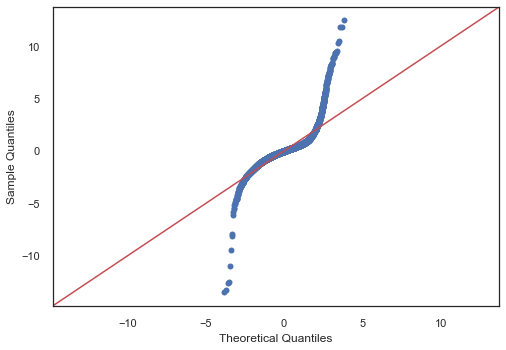

In [24]:
fig = sm.graphics.qqplot(mlr_model.resid, dist=stats.norm, line='45', fit=True)

In [25]:
features_df = df.drop(columns=['id', 'price','log_price','sqft_lot15','zipcode'])
str_features_col= "+".join(features_df)
mlr_model = smf.ols(formula=f'log_price~{str_features_col}', data=df).fit()
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     2656.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:10:15   Log-Likelihood:                 2121.5
No. Observations:               17176   AIC:                            -4177.
Df Residuals:                   17143   BIC:                            -3921.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -17.4104      2.790     -6.241      0.000     -22.878     -11.943
sqft_living                        0.0003   3.21e-06     80.349      0.000       0.000       0.000
sqft_lot                        7.327e-07   4.13e-08     17.760      0.000    6.52e-07    8.14e-07
floors                             0.0142      0.005      3.100      0.002       0.005       0.023
waterfront                         0.3404      0.023     14.872      0.000       0.296       0.385
condition                          0.2193      0.017     12.753      0.000       0.186       0.253
lat                                0.3849      0.019     20.769      0.000       0.349       0.421
long                              -0.0844      0.022     -3.753      0.000      -0.128      -0.040
median_age                        -0.0047      0.001     -6.829      0.000      -0.006      -0.003
population                     -3.194e-07   1.77e-07     -1.809      0.070   -6.66e-07    2.67e-08
population_density_per_sq_mile  2.516e-05   1.13e-06     22.217      0.000    2.29e-05    2.74e-05
median_home_value               1.317e-06   4.02e-08     32.744      0.000    1.24e-06     1.4e-06
median_household_income         -4.18e-07   1.56e-07     -2.676      0.007   -7.24e-07   -1.12e-07
bath_per_bed                       0.1749      0.011     15.741      0.000       0.153       0.197
basement                          -0.0300      0.004     -7.310      0.000      -0.038      -0.022
zip_price_level_low               -0.2383      0.010    -24.447      0.000      -0.257      -0.219
zip_price_level_medium            -0.0839      0.006    -14.721      0.000      -0.095      -0.073
zip_price_level_very_high          0.0130      0.013      0.977      0.328      -0.013       0.039
season_sold_warm_month             0.0234      0.003      6.982      0.000       0.017       0.030
year_sold_2015                     0.0396      0.004     11.255      0.000       0.033       0.047
age_2                             -0.0078      0.005     -1.555      0.120      -0.018       0.002
age_3                              0.0007      0.006      0.124      0.902      -0.011       0.012
age_4                              0.0266      0.008      3.168      0.002       0.010       0.043
renovated                          0.0510      0.009      5.979      0.000       0.034       0.068
bedrooms_2                         0.0945      0.006     16.495      0.000       0.083       0.106
bedrooms_3                         0.1294      0.007     17.493      0.000       0.115       0.144
bedrooms_4                         0.0211      0.016      1.339      0.181      -0.010       0.052
grade_low                          0.4734      0.066      7.140      0.000       0.343       0.603
grade_medium  

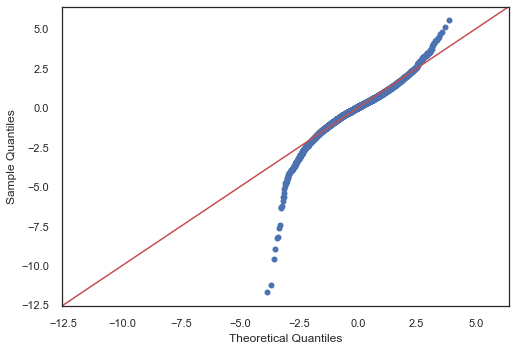

In [26]:
fig = sm.graphics.qqplot(mlr_model.resid, dist=stats.norm, line='45', fit=True)

# Model 1: Linear Model

In [59]:
df_poly2[kb_selected_columns].columns

Index(['sqft_living', 'median_home_value', 'sqft_living^2',
       'sqft_living condition', 'sqft_living zipcode', 'sqft_living lat',
       'sqft_living long', 'sqft_living median_age',
       'sqft_living median_home_value', 'sqft_living median_household_income',
       'sqft_living bath_per_bed', 'sqft_living grade_medium',
       'condition median_home_value', 'zipcode median_home_value',
       'lat median_home_value', 'long median_home_value',
       'median_age median_home_value', 'median_home_value^2',
       'median_home_value bath_per_bed', 'median_home_value grade_medium'],
      dtype='object')

In [60]:
target = df['price']
features_df = df.drop(columns=['id', 'price','log_price'])
features = kb_selected_columns

In [61]:
#your code here 
from sklearn.linear_model import LinearRegression

#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(df_poly2[kb_selected_columns], target)

#access output
print(lm.intercept_)
print(lm.coef_)
print("R^2: ", lm.score(df_poly2[kb_selected_columns], target))


-213307.83148445736
[-3.27693281e+04  1.31019199e+02 -1.07251701e-02 -1.86075345e+01
  3.02326121e-01  1.09745397e+02  1.56918721e+01 -2.94969929e+00
  4.56202998e-04 -1.07719032e-03  1.14455580e+02  6.64680036e+01
  1.63640352e-01 -2.08057982e-03 -2.77023813e-01 -7.13719506e-01
  4.06548782e-03 -8.39345309e-07 -3.00345619e-01 -8.19854703e-02]
R^2:  0.7478993438853513


In [62]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2[kb_selected_columns], target, random_state=9,test_size=0.2)

### 5.2) Fit your scaler to training the data.

In [63]:
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=df_poly2[kb_selected_columns].columns)
X_train

,sqft_living,median_home_value,sqft_living^2,sqft_living condition,sqft_living zipcode,sqft_living lat,sqft_living long,sqft_living median_age,sqft_living median_home_value,sqft_living median_household_income,sqft_living bath_per_bed,sqft_living grade_medium,condition median_home_value,zipcode median_home_value,lat median_home_value,long median_home_value,median_age median_home_value,median_home_value^2,median_home_value bath_per_bed,median_home_value grade_medium
0,0.917989,0.396363,0.617960,0.915009,0.917520,0.927264,-0.916360,0.532209,0.760630,0.980534,1.127402,-0.266643,0.407003,0.395505,0.404186,-0.393635,-0.003302,0.217449,0.871902,-0.263019
1,-0.288690,0.416629,-0.343398,-0.271003,-0.287913,-0.287612,0.285715,-0.085684,-0.073854,-0.359883,-0.196680,-0.266643,0.426531,0.418061,0.415202,-0.421994,0.637566,0.236609,0.318326,-0.263019
2,-0.658304,-0.407542,-0.547977,-0.634286,-0.657618,-0.658337,0.656356,-0.624140,-0.598553,-0.678013,-0.972805,-0.266643,-0.367598,-0.406292,-0.407890,0.403852,-0.372448,-0.453127,-1.089248,-0.263019
3,-0.669175,-1.841209,-0.553356,-0.644971,-0.670518,-0.677676,0.671189,-0.751824,-1.062493,-0.973241,-0.448202,-0.266643,-1.749007,-1.842487,-1.841873,1.842821,-1.669105,-1.216010,-1.147480,-0.263019
4,0.472279,0.259001,0.210534,0.476932,0.471150,0.471381,-0.467948,0.227794,0.374194,0.646856,0.193179,-0.266643,0.274648,0.257370,0.255899,-0.253041,-0.032596,0.090510,0.079883,-0.263019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13735,0.602731,-0.035989,0.323435,0.605150,0.604298,0.604895,-0.605505,0.128633,0.292413,-0.306026,-0.081699,-0.266643,-0.009589,-0.034621,-0.034438,0.033754,-0.466798,-0.164880,-0.472079,-0.263019
13736,-1.223595,-0.356500,-0.779323,-1.189896,-1.224336,-1.219290,1.224247,-1.202049,-0.891721,-0.882398,-1.159649,-0.266643,-0.318417,-0.357787,-0.347054,0.356340,-0.451223,-0.415737,-1.072679,-0.263019
13737,-0.419142,-1.057571,-0.420416,-0.399221,-0.420057,-0.427385,0.419446,-0.537241,-0.710214,-0.591602,-0.702868,-0.266643,-0.993933,-1.058723,-1.063841,1.057936,-1.058485,-0.867778,-1.093527,-0.263019
13738,-0.353916,0.493942,-0.382563,-0.335112,-0.353438,-0.348630,0.352108,-0.528178,-0.090081,-0.375713,-0.674572,-0.266643,0.501026,0.494941,0.500077,-0.497525,0.070561,0.310719,-0.432516,-0.263019


### 5.3) Transform the testing set with the scaler.

In [64]:
#transform the testing dat
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df_poly2[kb_selected_columns].columns)
X_test

,sqft_living,median_home_value,sqft_living^2,sqft_living condition,sqft_living zipcode,sqft_living lat,sqft_living long,sqft_living median_age,sqft_living median_home_value,sqft_living median_household_income,sqft_living bath_per_bed,sqft_living grade_medium,condition median_home_value,zipcode median_home_value,lat median_home_value,long median_home_value,median_age median_home_value,median_home_value^2,median_home_value bath_per_bed,median_home_value grade_medium
0,-0.571336,-0.303207,-0.503633,-0.548808,-0.570598,-0.565471,0.570491,-0.543105,-0.516432,-0.811967,-0.523658,-0.266643,-0.267066,-0.301918,-0.294210,0.301481,-0.284180,-0.375948,-0.375593,-0.263019
1,-0.582207,0.336314,-0.509304,-0.559493,-0.583488,-0.580049,0.583682,-0.429283,-0.307035,-0.282714,-0.529947,-0.266643,0.349143,0.333922,0.337273,-0.333850,0.486064,0.161330,-0.012309,-0.263019
2,-0.984433,1.470487,-0.693480,-0.954830,-0.984097,-0.981389,0.983276,-1.053840,-0.292133,-0.829701,-0.868603,-0.266643,1.441975,1.472644,1.471742,-1.476776,0.809756,1.385716,0.261434,-0.263019
3,0.472279,-0.523886,0.210534,0.476932,0.471904,0.469153,-0.471874,0.294968,-0.054643,0.010393,0.193179,-0.266643,-0.479702,-0.524549,-0.525666,0.524880,-0.585379,-0.535724,-0.396608,-0.263019
4,1.200635,1.514023,0.908091,1.192813,1.200989,1.202104,-1.197918,1.107985,1.732957,2.405863,0.429654,2.968523,1.483924,1.514136,1.509408,-1.509135,1.253199,1.439635,0.563181,4.014004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431,0.124407,-0.460835,-0.064864,0.135019,0.122908,0.133004,-0.124544,0.105175,-0.203365,-0.164967,-0.170630,-0.266643,-0.418949,-0.462711,-0.450705,0.461087,-0.417534,-0.491415,-0.518586,-0.263019
3432,0.580989,1.514023,0.304254,0.583780,0.581175,0.581783,-0.577923,0.530610,1.161844,1.703398,0.260551,-0.266643,1.483924,1.514136,1.508337,-1.508229,1.253199,1.439635,0.843730,-0.263019
3433,2.722573,0.496945,2.894077,2.688685,2.728532,2.737707,-2.731473,3.749622,2.120938,2.260058,2.206251,4.388346,0.503919,0.500656,0.505670,-0.501766,1.192538,0.313629,0.661997,3.070287
3434,-1.017046,-0.047999,-0.706225,-0.986885,-1.016950,-1.014501,1.016479,-1.111684,-0.701486,-0.880401,-0.419906,-0.266643,-0.021161,-0.047260,-0.044450,0.045226,-0.407507,-0.174780,0.634951,-0.263019


### 5.4) Fit the model to the training data.

In [65]:
# Fit the linear regression to the data
lm = lm.fit(X_train, y_train)

# Get the predictions values based on linear regression 
y_train_pred = lm.predict(X_train)

# Get the root mean squared error from the predictions
lin_train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training Root Mean Squared Error:' , lin_train_rmse)

Training Root Mean Squared Error: 173615.30913237226


### 5.5) Use the model to predict on the training set and the test set.

In [66]:
#use fitted model to predict on the test examples
y_test_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
lin_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Training: ', lin_train_rmse, "vs. Testing: ", lin_test_rmse)

Training:  173615.30913237226 vs. Testing:  185258.62734497237


In [67]:
X_train.columns

Index(['sqft_living', 'median_home_value', 'sqft_living^2',
       'sqft_living condition', 'sqft_living zipcode', 'sqft_living lat',
       'sqft_living long', 'sqft_living median_age',
       'sqft_living median_home_value', 'sqft_living median_household_income',
       'sqft_living bath_per_bed', 'sqft_living grade_medium',
       'condition median_home_value', 'zipcode median_home_value',
       'lat median_home_value', 'long median_home_value',
       'median_age median_home_value', 'median_home_value^2',
       'median_home_value bath_per_bed', 'median_home_value grade_medium'],
      dtype='object')

### 5.6) Evaluate the training and test predictions using RMSE.

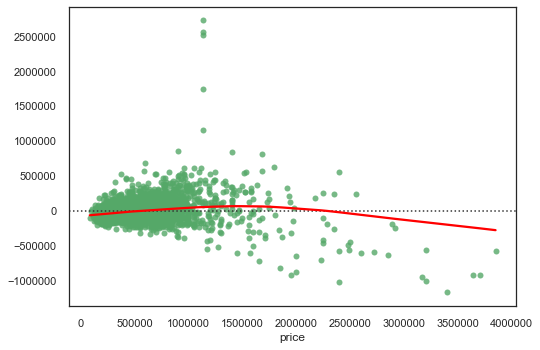

In [68]:
sns.residplot(y_test, y_test_pred, lowess=True, color="g", line_kws={"color": "red"});
plt.savefig("residual.png")

In [118]:
import pickle

pickle_out = open("model.pickle","wb")
pickle.dump(lm, pickle_out)
pickle_out.close()

In [119]:
import pickle

pickle_out = open("scaler.pickle","wb")
pickle.dump(scaler, pickle_out)
pickle_out.close()

# Model 1B: Linear w/ Recursive Feature Elimination

In [37]:
from sklearn.feature_selection import RFECV

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target, random_state=9,test_size=0.2)

In [39]:
ols = linear_model.LinearRegression()

In [40]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=2, scoring='neg_mean_squared_error', n_jobs=-1,verbose=1)

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

Fitting estimator with 34 features.


RFECV(cv=2,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [41]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [42]:
print(len(list(selected_rfe)))
list(selected_rfe)

33


['sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'zipcode',
 'lat',
 'long',
 'median_age',
 'population',
 'population_density_per_sq_mile',
 'median_home_value',
 'median_household_income',
 'bath_per_bed',
 'basement',
 'zip_price_level_low',
 'zip_price_level_medium',
 'zip_price_level_very_high',
 'season_sold_warm_month',
 'year_sold_2015',
 'age_2',
 'age_3',
 'age_4',
 'renovated',
 'bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'grade_low',
 'grade_medium',
 'view_1',
 'view_2',
 'view_3',
 'view_4']

In [43]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)
print("R^2: ", lm_rfe.score(features_df[selected_rfe], target))

Training Root Mean Squared Error: 163100.87082790665
Testing Root Mean Squared Error: 168947.17648453751
R^2:  0.7794192546230228


In [44]:
df[selected_rfe].head()

,sqft_living,sqft_lot,floors,waterfront,condition,zipcode,lat,long,median_age,population,population_density_per_sq_mile,median_home_value,median_household_income,bath_per_bed,basement,zip_price_level_low,zip_price_level_medium,zip_price_level_very_high,season_sold_warm_month,year_sold_2015,age_2,age_3,age_4,renovated,bedrooms_2,bedrooms_3,bedrooms_4,grade_low,grade_medium,view_1,view_2,view_3,view_4
0,2070,8893,1,0,1,98058,47.4388,-122.162,38,41938,2215,302200.0,77780.0,0.562500,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
1756,2410,8284,0,0,1,98034,47.7202,-122.220,36,40407,4428,364900.0,77688.0,0.750000,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
4109,1900,10454,0,0,1,98155,47.7748,-122.291,42,32778,4330,340900.0,72281.0,0.583333,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
4110,810,8494,0,0,1,98155,47.7389,-122.324,42,32778,4330,340900.0,72281.0,0.500000,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1761,3630,4911,1,0,1,98034,47.7180,-122.156,36,40407,4428,364900.0,77688.0,0.700000,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


# Model 2: Polynomial Model

In [45]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(features_df)
poly2_columns = poly_2.get_feature_names(features_df.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
print(df_poly2.shape)
df_poly2.head()

(17176, 629)


,sqft_living,sqft_lot,floors,waterfront,condition,zipcode,lat,long,sqft_lot15,median_age,population,population_density_per_sq_mile,median_home_value,median_household_income,bath_per_bed,basement,zip_price_level_low,zip_price_level_medium,zip_price_level_very_high,season_sold_warm_month,year_sold_2015,age_2,age_3,age_4,renovated,bedrooms_2,bedrooms_3,bedrooms_4,grade_low,grade_medium,view_1,view_2,view_3,view_4,sqft_living^2,sqft_living sqft_lot,sqft_living floors,sqft_living waterfront,sqft_living condition,sqft_living zipcode,sqft_living lat,sqft_living long,sqft_living sqft_lot15,sqft_living median_age,sqft_living population,sqft_living population_density_per_sq_mile,sqft_living median_home_value,sqft_living median_household_income,sqft_living bath_per_bed,sqft_living basement,sqft_living zip_price_level_low,sqft_living zip_price_level_medium,sqft_living zip_price_level_very_high,sqft_living season_sold_warm_month,sqft_living year_sold_2015,sqft_living age_2,sqft_living age_3,sqft_living age_4,sqft_living renovated,sqft_living bedrooms_2,sqft_living bedrooms_3,sqft_living bedrooms_4,sqft_living grade_low,sqft_living grade_medium,sqft_living view_1,sqft_living view_2,sqft_living view_3,sqft_living view_4,sqft_lot^2,sqft_lot floors,sqft_lot waterfront,sqft_lot condition,sqft_lot zipcode,sqft_lot lat,sqft_lot long,sqft_lot sqft_lot15,sqft_lot median_age,sqft_lot population,sqft_lot population_density_per_sq_mile,sqft_lot median_home_value,sqft_lot median_household_income,sqft_lot bath_per_bed,sqft_lot basement,sqft_lot zip_price_level_low,sqft_lot zip_price_level_medium,sqft_lot zip_price_level_very_high,sqft_lot season_sold_warm_month,sqft_lot year_sold_2015,sqft_lot age_2,sqft_lot age_3,sqft_lot age_4,sqft_lot renovated,sqft_lot bedrooms_2,sqft_lot bedrooms_3,sqft_lot bedrooms_4,sqft_lot grade_low,sqft_lot grade_medium,sqft_lot view_1,sqft_lot view_2,sqft_lot view_3,sqft_lot view_4,floors^2,floors waterfront,floors condition,floors zipcode,floors lat,floors long,floors sqft_lot15,floors median_age,floors population,floors population_density_per_sq_mile,floors median_home_value,floors median_household_income,floors bath_per_bed,floors basement,floors zip_price_level_low,floors zip_price_level_medium,floors zip_price_level_very_high,floors season_sold_warm_month,floors year_sold_2015,floors age_2,floors age_3,floors age_4,floors renovated,floors bedrooms_2,floors bedrooms_3,floors bedrooms_4,floors grade_low,floors grade_medium,floors view_1,floors view_2,floors view_3,floors view_4,waterfront^2,waterfront condition,waterfront zipcode,waterfront lat,waterfront long,waterfront sqft_lot15,waterfront median_age,waterfront population,waterfront population_density_per_sq_mile,waterfront median_home_value,waterfront median_household_income,waterfront bath_per_bed,waterfront basement,waterfront zip_price_level_low,waterfront zip_price_level_medium,waterfront zip_price_level_very_high,waterfront season_sold_warm_month,...,zip_price_level_medium year_sold_2015,zip_price_level_medium age_2,zip_price_level_medium age_3,zip_price_level_medium age_4,zip_price_level_medium renovated,zip_price_level_medium bedrooms_2,zip_price_level_medium bedrooms_3,zip_price_level_medium bedrooms_4,zip_price_level_medium grade_low,zip_price_level_medium grade_medium,zip_price_level_medium view_1,zip_price_level_medium view_2,zip_price_level_medium view_3,zip_price_level_medium view_4,zip_price_level_very_high^2,zip_price_level_very_high season_sold_warm_month,zip_price_level_very_high year_sold_2015,zip_price_level_very_high age_2,zip_price_level_very_high age_3,zip_price_level_very_high age_4,zip_price_level_very_high renovated,zip_price_level_very_high bedrooms_2,zip_price_level_very_high bedrooms_3,zip_price_level_very_high bedrooms_4,zip_price_level_very_high grade_low,zip_price_level_very_high grade_medium,zip_price_level_very_high view_1,zip_price_level_very_high view_2,zip_price_level_very_high view_3,zip_price_level_very_high view_4,season_sold_warm

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=9,test_size=0.2)

In [47]:
scaler2 = StandardScaler()
# fit the scaler to the training data
scaler2.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=df_poly2.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=df_poly2.columns)

In [48]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 120495.99557262026


In [49]:
y_pred = lm_2.predict(X_test)

poly_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , poly_test_rmse)
print('Training: ', int(poly_train_rmse), "vs. Testing: ", int(poly_test_rmse))

Testing Root Mean Squared Error: 5572252122548579.0


NameError: name 'poly_train_rmse' is not defined

In [50]:
len(lm_2.coef_)

629

In [51]:
print("R^2: ", lm_2.score(df_poly2, target))

R^2:  -4.203549633925297e+31


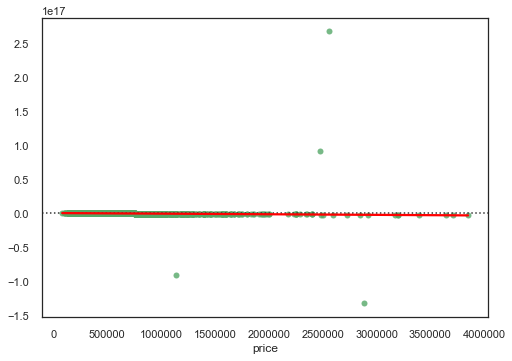

In [52]:
sns.residplot(y_test, y_pred, lowess=True, color="g", line_kws={"color": "red"});

# Model 2A: Polynomial + RFE Model

In [716]:
X_train.shape

(13740, 527)

In [717]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=2, cv=7, scoring='neg_mean_squared_error', n_jobs=-1,verbose=1)

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

Fitting estimator with 527 features.
Fitting estimator with 525 features.
Fitting estimator with 523 features.
Fitting estimator with 521 features.
Fitting estimator with 519 features.
Fitting estimator with 517 features.
Fitting estimator with 515 features.
Fitting estimator with 513 features.
Fitting estimator with 511 features.
Fitting estimator with 509 features.
Fitting estimator with 507 features.
Fitting estimator with 505 features.
Fitting estimator with 503 features.
Fitting estimator with 501 features.
Fitting estimator with 499 features.
Fitting estimator with 497 features.
Fitting estimator with 495 features.
Fitting estimator with 493 features.
Fitting estimator with 491 features.
Fitting estimator with 489 features.
Fitting estimator with 487 features.
Fitting estimator with 485 features.
Fitting estimator with 483 features.
Fitting estimator with 481 features.
Fitting estimator with 479 features.
Fitting estimator with 477 features.
Fitting estimator with 475 features.
F

Fitting estimator with 77 features.
Fitting estimator with 75 features.
Fitting estimator with 73 features.
Fitting estimator with 71 features.
Fitting estimator with 69 features.
Fitting estimator with 67 features.
Fitting estimator with 65 features.
Fitting estimator with 63 features.
Fitting estimator with 61 features.
Fitting estimator with 59 features.
Fitting estimator with 57 features.
Fitting estimator with 55 features.
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 features.
Fitting estimator with 35 features.
Fitting estimator with 33 features.
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
Fitting estimator with 25 features.
Fitting estimator with 23 fe

RFECV(cv=7,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=2, verbose=1)

In [718]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [719]:
print(list(selected_rfe))

['sqft_living', 'basement', 'age_2', 'grade_low', 'grade_medium', 'sqft_living grade_low', 'sqft_living grade_medium', 'basement^2', 'basement grade_low', 'basement grade_medium', 'age_2 grade_low', 'grade_low^2', 'grade_medium^2']


In [720]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data

lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


train_poly_RFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , train_poly_RFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

test_poly_RFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , test_poly_RFE_rmse)

Training Root Mean Squared Error: 236818.29526753904
Testing Root Mean Squared Error: 239521.05040095156


# Model 3: Lasso + Polynomial

In [773]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training Error: '+ str(train_rmse_lasso01) )
print('Testing Error: '+ str(test_rmse_lasso01) )
print("R^2: ", lasso.score(features_df, target))

Training Error: 97446.03543378106
Testing Error: 168944.46822921038
R^2:  0.7794208719395096


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182621213228750.38, tolerance: 169242806726.24448
  positive)


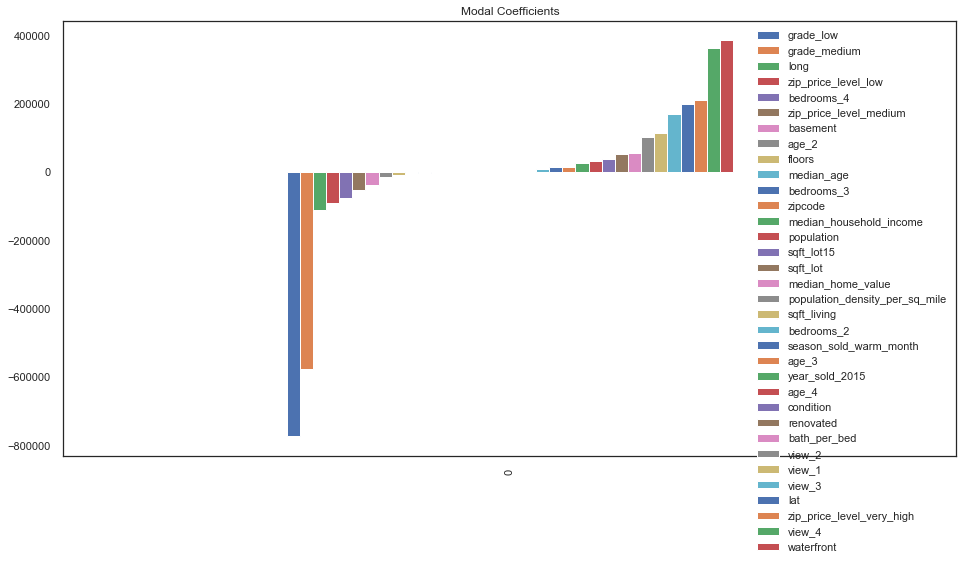

In [774]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=True, figsize=(16,8))

# Model 4: KBest + Polynomial

In [53]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=20)

selector.fit(X_train, y_train)

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=20, score_func=<function f_regression at 0x7fef6e0af560>)

In [54]:
kb_selected_columns = X_train.columns[selector.get_support()]
kb_removed_columns = X_train.columns[~selector.get_support()]

In [55]:
list(kb_removed_columns)


['sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'zipcode',
 'lat',
 'long',
 'sqft_lot15',
 'median_age',
 'population',
 'population_density_per_sq_mile',
 'median_household_income',
 'bath_per_bed',
 'basement',
 'zip_price_level_low',
 'zip_price_level_medium',
 'zip_price_level_very_high',
 'season_sold_warm_month',
 'year_sold_2015',
 'age_2',
 'age_3',
 'age_4',
 'renovated',
 'bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'grade_low',
 'grade_medium',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'sqft_living sqft_lot',
 'sqft_living floors',
 'sqft_living waterfront',
 'sqft_living sqft_lot15',
 'sqft_living population',
 'sqft_living population_density_per_sq_mile',
 'sqft_living basement',
 'sqft_living zip_price_level_low',
 'sqft_living zip_price_level_medium',
 'sqft_living zip_price_level_very_high',
 'sqft_living season_sold_warm_month',
 'sqft_living year_sold_2015',
 'sqft_living age_2',
 'sqft_living age_3',
 'sqft_living age_4',
 'sqft_living renovated',
 'sqft_li

In [56]:
list(kb_selected_columns)

['sqft_living',
 'median_home_value',
 'sqft_living^2',
 'sqft_living condition',
 'sqft_living zipcode',
 'sqft_living lat',
 'sqft_living long',
 'sqft_living median_age',
 'sqft_living median_home_value',
 'sqft_living median_household_income',
 'sqft_living bath_per_bed',
 'sqft_living grade_medium',
 'condition median_home_value',
 'zipcode median_home_value',
 'lat median_home_value',
 'long median_home_value',
 'median_age median_home_value',
 'median_home_value^2',
 'median_home_value bath_per_bed',
 'median_home_value grade_medium']

In [57]:
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[kb_selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[kb_selected_columns])

trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))

print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[kb_selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 173615.30913237226
Testing Root Mean Squared Error: 185258.62734497237


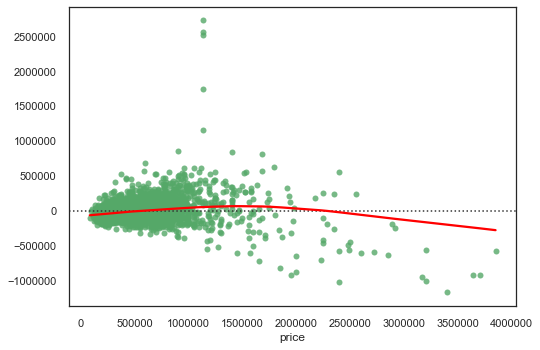

In [58]:
sns.residplot(y_test, y_kbest, lowess=True, color="g", line_kws={"color": "red"});

In [788]:
print('Original: \t',   lin_test_rmse, '\n',
      'Lin_RFE:  \t', testRFE_rmse, '\n',
      'Poly:  \t',      poly_test_rmse, '\n',
      #'Poly RFE:   \t', test_poly_RFE_rmse, '\n'
      'KBest:   \t',    testK_rmse, '\n',
      'Lasso 0.01: \t',  test_rmse_lasso01, '\n')

Original: 	 168946.3516537307 
 Lin_RFE:  	 168947.17648453751 
 Poly:  	 1311062565560923.0 
 KBest:   	 171709.15404000116 
 Lasso 0.01: 	 168944.46822921038 



### 5.7) Determine if your model is overfit.

In [434]:
import pickle

pickle_out = open('model.pickle','wb')
pickle.dump(lm_2, pickle_out)
pickle_out.close()

In [435]:
import pickle

pickle_out = open("scaler.pickle","wb")
pickle.dump(scaler, pickle_out)
pickle_out.close()

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [60]:
# your code here

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [ ]:
import pickle

pickle_out = open("model.pickle","wb")
pickle.dump(lm_2, pickle_out)
pickle_out.close()

In [ ]:
import pickle

pickle_out = open("scaler.pickle","wb")
pickle.dump(scaler2, pickle_out)
pickle_out.close()

## Step 7: Evaluate your different models in order to determine the best model overall.

## Step 8:  Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/